# Graph Neural Network for Human vs LLM Code Classification

This notebook implements a GIN (Graph Isomorphism Network) to distinguish between human-written and LLM-generated Python code using Abstract Syntax Tree (AST) representations.

## 1. Setup and Imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve


In [2]:
# Import custom modules
from graphdataset import CodeGraphDataset
from process import PythonCodeProcessor

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Data Loading and Exploration

In [3]:
# Configuration
DATA_DIR = 'dataset/python'
VALID_FILE = os.path.join(DATA_DIR, 'valid_no_comment.jsonl')
TEST_FILE = os.path.join(DATA_DIR, 'test_no_comment.jsonl')

MAX_NODES = 500  # Maximum nodes in AST
EMBEDDING_SIZE = 128  # Dimension of node embeddings
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
HIDDEN_DIM = 256
NUM_LAYERS = 5

# NEW: Optimization parameters
MAX_SAMPLES_TRAIN = 100  # Limit training samples (None = all)
MAX_SAMPLES_TEST = 100   # Limit test samples (None = all)
TIMEOUT_MINUTES = 200      # Stop processing after 10 minutes

print("Configuration:")
print(f"  Max nodes: {MAX_NODES}")
print(f"  Embedding size: {EMBEDDING_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  GIN layers: {NUM_LAYERS}")
print(f"  Max training samples: {MAX_SAMPLES_TRAIN}")
print(f"  Max test samples: {MAX_SAMPLES_TEST}")
print(f"  Timeout: {TIMEOUT_MINUTES} minutes")



Configuration:
  Max nodes: 500
  Embedding size: 128
  Batch size: 64
  Learning rate: 0.001
  Epochs: 30
  Hidden dim: 256
  GIN layers: 5
  Max training samples: 100
  Max test samples: 100
  Timeout: 200 minutes


In [4]:
# Load datasets with limits and timeout
print("\n" + "="*70)
print("Loading validation dataset...")
print("="*70)
valid_dataset = CodeGraphDataset(
    jsonl_path=VALID_FILE,
    max_nodes=MAX_NODES,
    embedding_size=EMBEDDING_SIZE,
    force_reprocess=True,
    max_samples=MAX_SAMPLES_TRAIN,  # LIMIT SAMPLES
    timeout_minutes=TIMEOUT_MINUTES  # TIMEOUT
)

print("\n" + "="*70)
print("Loading test dataset (sharing vocabulary)...")
print("="*70)
test_dataset = CodeGraphDataset(
    jsonl_path=TEST_FILE,
    processor=valid_dataset.processor,  # Share vocabulary
    max_nodes=MAX_NODES,
    max_samples=MAX_SAMPLES_TEST,  # LIMIT SAMPLES
    timeout_minutes=TIMEOUT_MINUTES  # TIMEOUT
)

print(f"\n{'='*70}")
print(f"Validation set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"{'='*70}")


Loading validation dataset...
Processing graphs from dataset/python/valid_no_comment.jsonl
  Limiting to 100 samples
  Timeout: 200 minutes
Loaded 100 examples from dataset/python/valid_no_comment.jsonl
Extracting AST node sequences from corpus...


Extracting tokens:   0%|          | 0/1 [00:00<?, ?batch/s]

Conversion failed for snippet: bad input: type=1, value='print', context=('', (8, 12))
Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 11)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 11)


Extracting tokens: 100%|██████████| 1/1 [00:16<00:00, 16.10s/batch]


Total token sequences for embedding: 199
Training Word2Vec embeddings on AST tokens...
Vocabulary size: 506
Processing code into graphs...


Processing samples:   3%|▎         | 3/100 [00:01<00:59,  1.62sample/s]

Conversion failed for snippet: bad input: type=1, value='print', context=('', (8, 12))
Conversion failed for snippet: bad input: type=1, value='print', context=('', (8, 12))
Conversion failed for snippet: bad input: type=1, value='print', context=('', (8, 12))
Conversion failed for snippet: bad input: type=1, value='print', context=('', (8, 12))


Processing samples:  54%|█████▍    | 54/100 [00:35<00:27,  1.70sample/s]

Conversion failed for snippet: unindent does not match any outer indentation level (<tokenize>, line 11)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 11)


Processing samples: 100%|██████████| 100/100 [01:15<00:00,  1.32sample/s]


Successfully processed 97 examples
Failed to process 3 examples
Saving to cache: dataset/python/cached_graphs/valid_no_comment_n100_graphs.pkl
Cache saved successfully

Loading test dataset (sharing vocabulary)...
Loading cached graphs from dataset/python/cached_graphs/test_no_comment_n100_graphs.pkl
Loaded 98 cached examples
Vocabulary size: 506

Validation set size: 97
Test set size: 98


In [5]:
# Display dataset statistics
print("\n" + "="*70)
print("VALIDATION DATASET STATISTICS")
print("="*70)
valid_stats = valid_dataset.get_stats()
for key, value in valid_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

print("\n" + "="*70)
print("TEST DATASET STATISTICS")
print("="*70)
test_stats = test_dataset.get_stats()
for key, value in test_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")


VALIDATION DATASET STATISTICS
total_samples: 97
avg_code_nodes: 61.72
max_code_nodes: 241
min_code_nodes: 3
avg_contrast_nodes: 76.15
max_contrast_nodes: 412
min_contrast_nodes: 3

TEST DATASET STATISTICS
total_samples: 98
avg_code_nodes: 75.87
max_code_nodes: 326
min_code_nodes: 3
avg_contrast_nodes: 72.96
max_contrast_nodes: 381
min_contrast_nodes: 5


In [6]:
# Examine a sample
sample = valid_dataset[0]
print("\n" + "="*70)
print("SAMPLE DATA POINT")
print("="*70)
print(f"Index: {sample['index']}")
print(f"\nCode Graph:")
print(f"  Shape: {sample['code_graph'].shape}")
print(f"  Number of nodes: {sample['code_num_nodes']}")
print(f"  Sequence length: {len(sample['code_sequence'])}")
print(f"  First 15 tokens: {sample['code_sequence'][:15]}")
print(f"\nContrast Graph:")
print(f"  Shape: {sample['contrast_graph'].shape}")
print(f"  Number of nodes: {sample['contrast_num_nodes']}")
print(f"  Sequence length: {len(sample['contrast_sequence'])}")
print(f"  First 15 tokens: {sample['contrast_sequence'][:15]}")


SAMPLE DATA POINT
Index: gp266290

Code Graph:
  Shape: torch.Size([500, 500])
  Number of nodes: 13
  Sequence length: 13
  First 15 tokens: [12, 8, 5, 1, 4, 3, 1, 0, 1, 0, 10, 1, 0]

Contrast Graph:
  Shape: torch.Size([500, 500])
  Number of nodes: 60
  Sequence length: 60
  First 15 tokens: [12, 8, 9, 3, 2, 1, 0, 0, 3, 2, 266, 0, 1, 0, 5]


In [7]:
# Get embedding matrix
embedding_matrix = valid_dataset.get_embedding_matrix()
print(f"\nEmbedding matrix shape: {embedding_matrix.shape}")
print(f"Vocabulary size: {embedding_matrix.shape[0] - 1}")


Embedding matrix shape: torch.Size([507, 128])
Vocabulary size: 506


## 3. GIN Model Architecture

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GINLayer(nn.Module):
    """Graph Isomorphism Network Layer.
    
    Implements: h_v^(k) = MLP^(k)((1 + epsilon^(k)) * h_v^(k-1) + sum_{u in N(v)} h_u^(k-1))
    """
    def __init__(self, input_dim, hidden_dim, output_dim, eps_learnable=True):
        super(GINLayer, self).__init__()
        
        # MLP for node update
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU()
        )
        
        # Learnable epsilon parameter
        if eps_learnable:
            self.eps = nn.Parameter(torch.zeros(1))
        else:
            self.register_buffer('eps', torch.zeros(1))
    
    def forward(self, x, adj):
        """
        Args:
            x: Node features [batch_size, num_nodes, feature_dim]
            adj: Adjacency matrix [batch_size, num_nodes, num_nodes]
        
        Returns:
            Updated node features [batch_size, num_nodes, output_dim]
        """
        # Extract dimensions FIRST (critical!)
        batch_size, num_nodes, feature_dim = x.size()
        
        # Aggregate neighbor features: sum_{u in N(v)} h_u
        neighbor_sum = torch.bmm(adj, x)  # [batch_size, num_nodes, feature_dim]
        
        # Remove self-loop from aggregation (we'll add it back with epsilon)
        # Create diagonal mask for each batch
        eye = torch.eye(num_nodes, device=adj.device).unsqueeze(0).expand(batch_size, -1, -1)
        self_features = torch.bmm(eye, x)
        neighbor_sum = neighbor_sum - self_features
        
        # Apply GIN update rule: (1 + eps) * h + sum(neighbors)
        out = (1 + self.eps) * x + neighbor_sum
        
        # Apply MLP
        out = out.view(batch_size * num_nodes, feature_dim)
        out = self.mlp(out)
        out = out.view(batch_size, num_nodes, -1)
        
        return out


class GINNetwork(nn.Module):
    """Graph Isomorphism Network for code classification."""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, 
                 num_classes=2, dropout=0.3, pretrained_embeddings=None):
        super(GINNetwork, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Token embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # Optionally freeze embeddings
            # self.embedding.weight.requires_grad = False
        
        # GIN layers
        self.gin_layers = nn.ModuleList()
        
        # First layer
        self.gin_layers.append(
            GINLayer(embedding_dim, hidden_dim, hidden_dim, eps_learnable=True)
        )
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.gin_layers.append(
                GINLayer(hidden_dim, hidden_dim, hidden_dim, eps_learnable=True)
            )
        
        # Readout MLP (for graph-level classification)
        self.readout = nn.Sequential(
            nn.Linear(hidden_dim * num_layers, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, sequences, adj_matrices, num_nodes_list):
        """
        Args:
            sequences: LIST of token sequences (Python lists!)
            adj_matrices: Adjacency matrices [batch_size, max_nodes, max_nodes]
            num_nodes_list: List of actual number of nodes
        
        Returns:
            logits: [batch_size, num_classes]
        """
        batch_size = adj_matrices.size(0)
        max_nodes = adj_matrices.size(1)
        
        # FIX: Convert list of sequences to padded tensor, aligned with actual node counts
        node_features = torch.zeros(batch_size, max_nodes, dtype=torch.long, 
                                    device=adj_matrices.device)
        
        for i, seq in enumerate(sequences):
            # Get actual number of nodes for this graph
            num_nodes = num_nodes_list[i]
            # Use min of sequence length and actual nodes to align features with graph structure
            seq_len = min(len(seq), num_nodes)
            # Convert sequence to tensor and pad/truncate to match actual node count
            seq_tensor = torch.tensor(seq[:seq_len], dtype=torch.long, device=adj_matrices.device)
            # Pad with zeros (padding_idx=0) if sequence is shorter than num_nodes
            if seq_len < num_nodes:
                padding = torch.zeros(num_nodes - seq_len, dtype=torch.long, device=adj_matrices.device)
                seq_tensor = torch.cat([seq_tensor, padding])
            node_features[i, :num_nodes] = seq_tensor
        
        # Embed tokens
        x = self.embedding(node_features)
        
        # Apply GIN layers
        layer_outputs = []
        for layer in self.gin_layers:
            x = layer(x, adj_matrices)
            x = F.dropout(x, p=self.dropout, training=self.training)
            layer_outputs.append(x)
        
        # Graph-level readout with masking
        graph_representations = []
        for layer_out in layer_outputs:
            mask = torch.zeros(batch_size, max_nodes, 1, device=layer_out.device)
            for i, num_nodes in enumerate(num_nodes_list):
                mask[i, :num_nodes, :] = 1.0
            
            masked_out = layer_out * mask
            graph_rep = masked_out.sum(dim=1)
            graph_representations.append(graph_rep)
        
        # Concatenate and classify
        graph_rep = torch.cat(graph_representations, dim=1)
        logits = self.readout(graph_rep)
        
        return logits


class SiameseGNN(nn.Module):
    """Siamese network for comparing code and contrast samples."""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
                 num_classes=2, dropout=0.3, pretrained_embeddings=None):
        super(SiameseGNN, self).__init__()
        
        # Shared GNN encoder
        self.gnn = GINNetwork(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_classes=hidden_dim * num_layers,  # Output embedding instead of class
            dropout=dropout,
            pretrained_embeddings=pretrained_embeddings
        )
        
        # Classifier on combined representations
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * num_layers * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, code_seq, code_adj, code_num_nodes,
                contrast_seq, contrast_adj, contrast_num_nodes):
        """
        Args:
            code_seq: Token sequences for code [batch_size, max_seq_len]
            code_adj: Adjacency matrices for code [batch_size, max_nodes, max_nodes]
            code_num_nodes: Number of nodes for each code graph [batch_size]
            contrast_seq: Token sequences for contrast [batch_size, max_seq_len]
            contrast_adj: Adjacency matrices for contrast [batch_size, max_nodes, max_nodes]
            contrast_num_nodes: Number of nodes for each contrast graph [batch_size]
        
        Returns:
            logits: [batch_size, num_classes]
        """
        # Encode both graphs
        code_embedding = self.gnn(code_seq, code_adj, code_num_nodes)
        contrast_embedding = self.gnn(contrast_seq, contrast_adj, contrast_num_nodes)
        
        # Concatenate embeddings
        combined = torch.cat([code_embedding, contrast_embedding], dim=1)
        
        # Classify
        logits = self.classifier(combined)
        
        return logits


print("GIN Model Architecture defined successfully!")

GIN Model Architecture defined successfully!


## 4. Training Setup

In [9]:
def collate_code_batch(batch):
    """Custom collate function to handle variable-length sequences."""
    indices = [item['index'] for item in batch]
    code_graphs = torch.stack([item['code_graph'] for item in batch])
    contrast_graphs = torch.stack([item['contrast_graph'] for item in batch])
    code_num_nodes = [item['code_num_nodes'] for item in batch]
    contrast_num_nodes = [item['contrast_num_nodes'] for item in batch]
    code_sequences = [item['code_sequence'] for item in batch]
    contrast_sequences = [item['contrast_sequence'] for item in batch]
    
    return {
        'index': indices,
        'code_graph': code_graphs,
        'contrast_graph': contrast_graphs,
        'code_num_nodes': code_num_nodes,
        'contrast_num_nodes': contrast_num_nodes,
        'code_sequence': code_sequences,
        'contrast_sequence': contrast_sequences
    }

# Create data loaders WITH CUSTOM COLLATE FUNCTION
train_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_code_batch  # ← KEY FIX
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_code_batch  # ← KEY FIX
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 2
Test batches: 2


In [10]:
# Initialize model
vocab_size = embedding_matrix.shape[0]

model = SiameseGNN(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_SIZE,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=2,
    dropout=0.3,
    pretrained_embeddings=embedding_matrix
).to(device)

print(f"\nModel initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model initialized with 2,008,199 parameters
Trainable parameters: 2,008,199


In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)

print("Training setup complete!")

Training setup complete!


/Users/kyleenliao/anaconda3/envs/cs224w/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 5. Training Loop

In [23]:
def train_epoch(model, loader, criterion, optimizer, device):
    """
    Train for one epoch, learning to distinguish code from contrast.
    
    Creates labels dynamically:
    - code samples → target = 0
    - contrast samples → target = 1
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []  # Using 'targets' instead of 'labels' for clarity
    
    progress_bar = tqdm(loader, desc='Training', leave=False)
    
    for batch in progress_bar:
        batch_size = len(batch['code_sequence'])
        
        # Move data to device
        code_graph = batch['code_graph'].to(device)
        contrast_graph = batch['contrast_graph'].to(device)
        
        code_num_nodes = batch['code_num_nodes']
        contrast_num_nodes = batch['contrast_num_nodes']
        
        code_seq = batch['code_sequence']
        contrast_seq = batch['contrast_sequence']
        
        optimizer.zero_grad()
        
        # === Forward pass for CODE samples (target = 0) ===
        code_logits = model(
            code_seq, code_graph, code_num_nodes,
            contrast_seq, contrast_graph, contrast_num_nodes
        )
        code_targets = torch.zeros(batch_size, dtype=torch.long).to(device)
        code_loss = criterion(code_logits, code_targets)
        
        # === Forward pass for CONTRAST samples (target = 1) ===
        contrast_logits = model(
            contrast_seq, contrast_graph, contrast_num_nodes,
            code_seq, code_graph, code_num_nodes
        )
        contrast_targets = torch.ones(batch_size, dtype=torch.long).to(device)
        contrast_loss = criterion(contrast_logits, contrast_targets)
        
        # Combined loss
        loss = (code_loss + contrast_loss) / 2
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        
        # Track predictions
        _, code_preds = torch.max(code_logits, 1)
        _, contrast_preds = torch.max(contrast_logits, 1)
        
        all_preds.extend(code_preds.cpu().numpy())
        all_preds.extend(contrast_preds.cpu().numpy())
        all_targets.extend(code_targets.cpu().numpy())
        all_targets.extend(contrast_targets.cpu().numpy())
        
        # Update progress bar
        current_acc = accuracy_score(all_targets, all_preds) * 100
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_acc:.2f}%'
        })
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_targets, all_preds) * 100
    
    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    """
    Evaluate model's ability to distinguish code from contrast.
    
    For each sample pair in the dataset:
    - Code sample should be classified as 0 (real code)
    - Contrast sample should be classified as 1 (negative/contrast)
    
    Evaluating whether the model can distinguish code from contrast.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating', leave=False):
            batch_size = len(batch['code_sequence'])
            
            # Move data to device
            code_graph = batch['code_graph'].to(device)
            contrast_graph = batch['contrast_graph'].to(device)
            
            code_num_nodes = batch['code_num_nodes']
            contrast_num_nodes = batch['contrast_num_nodes']
            
            code_seq = batch['code_sequence']
            contrast_seq = batch['contrast_sequence']
            
            # === Evaluate CODE samples (should predict 0 = "code") ===
            code_logits = model(
                code_seq, code_graph, code_num_nodes,
                contrast_seq, contrast_graph, contrast_num_nodes
            )
            code_labels = torch.zeros(batch_size, dtype=torch.long).to(device)
            code_loss = criterion(code_logits, code_labels)
            
            # Get predictions for code samples
            code_probs = F.softmax(code_logits, dim=1)
            _, code_preds = torch.max(code_logits, 1)
            
            all_preds.extend(code_preds.cpu().numpy())
            all_labels.extend(code_labels.cpu().numpy())
            all_probs.extend(code_probs[:, 0].cpu().numpy())  # Probability of being "code"
            
            # === Evaluate CONTRAST samples (should predict 1 = "contrast") ===
            contrast_logits = model(
                contrast_seq, contrast_graph, contrast_num_nodes,
                code_seq, code_graph, code_num_nodes
            )
            contrast_labels = torch.ones(batch_size, dtype=torch.long).to(device)
            contrast_loss = criterion(contrast_logits, contrast_labels)
            
            # Get predictions for contrast samples
            contrast_probs = F.softmax(contrast_logits, dim=1)
            _, contrast_preds = torch.max(contrast_logits, 1)
            
            all_preds.extend(contrast_preds.cpu().numpy())
            all_labels.extend(contrast_labels.cpu().numpy())
            all_probs.extend(contrast_probs[:, 0].cpu().numpy())  # Probability of being "code"
            
            # Combined loss
            loss = (code_loss + contrast_loss) / 2
            total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    # For binary classification: class 1 is "contrast", class 0 is "code"
    # We want to see if model can identify contrast (positive class)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', zero_division=0
    )
    
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100,
        'auc': auc,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

print("Training functions defined!")

Training functions defined!


In [13]:
# Training loop
train_losses = []
train_accs = []
test_losses = []
test_accs = []
test_f1s = []

best_test_f1 = 0
best_model_state = None

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    test_metrics = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_metrics['loss'])
    test_accs.append(test_metrics['accuracy'])
    test_f1s.append(test_metrics['f1'])
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss:  {test_metrics['loss']:.4f} | Test Acc:  {test_metrics['accuracy']:.2f}%")
    print(f"Test Precision: {test_metrics['precision']:.2f}% | Test Recall: {test_metrics['recall']:.2f}%")
    print(f"Test F1: {test_metrics['f1']:.2f}% | Test AUC: {test_metrics['auc']:.4f}")
    
    # Learning rate scheduling
    scheduler.step(test_metrics['f1'])
    
    # Save best model
    if test_metrics['f1'] > best_test_f1:
        best_test_f1 = test_metrics['f1']
        best_model_state = model.state_dict().copy()
        print(f"*** New best F1: {best_test_f1:.2f}% ***")
    
    print()

print(f"\nTraining complete! Best test F1: {best_test_f1:.2f}%")

# Load best model
model.load_state_dict(best_model_state)
torch.save(best_model_state, 'best_model.pth')
print("Best model saved to 'best_model.pth'")

Starting training...

Epoch 1/30
----------------------------------------------------------------------


Train Loss: 51.0468 | Train Acc: 49.48%
Test Loss:  0.8641 | Test Acc:  50.00%
Test Precision: 0.00% | Test Recall: 0.00%
Test F1: 0.00% | Test AUC: 0.5193

Epoch 2/30
----------------------------------------------------------------------


Train Loss: 14.0937 | Train Acc: 50.00%
Test Loss:  0.7719 | Test Acc:  50.51%
Test Precision: 60.00% | Test Recall: 3.06%
Test F1: 5.83% | Test AUC: 0.5168
*** New best F1: 5.83% ***

Epoch 3/30
----------------------------------------------------------------------


Train Loss: 2.1053 | Train Acc: 52.06%
Test Loss:  0.7400 | Test Acc:  46.43%
Test Precision: 44.62% | Test Recall: 29.59%
Test F1: 35.58% | Test AUC: 0.5374
*** New best F1: 35.58% ***

Epoch 4/30
----------------------------------------------------------------------


Train Loss: 1.1226 | Train Acc: 56.70%
Test Loss:  0.6952 | Test Acc:  51.02%
Test Precision: 50.60% | Test Recall: 85.71%
Test F1: 63.64% | Test AUC: 0.5030
*** New best F1: 63.64% ***

Epoch 5/30
----------------------------------------------------------------------


Train Loss: 0.7905 | Train Acc: 56.70%
Test Loss:  0.7486 | Test Acc:  47.45%
Test Precision: 48.41% | Test Recall: 77.55%
Test F1: 59.61% | Test AUC: 0.5487

Epoch 6/30
----------------------------------------------------------------------


Train Loss: 0.7700 | Train Acc: 56.19%
Test Loss:  0.7071 | Test Acc:  47.96%
Test Precision: 44.74% | Test Recall: 17.35%
Test F1: 25.00% | Test AUC: 0.5381

Epoch 7/30
----------------------------------------------------------------------


Train Loss: 0.7043 | Train Acc: 51.03%
Test Loss:  0.7331 | Test Acc:  47.96%
Test Precision: 48.84% | Test Recall: 85.71%
Test F1: 62.22% | Test AUC: 0.4985

Epoch 8/30
----------------------------------------------------------------------


Train Loss: 0.7420 | Train Acc: 59.79%
Test Loss:  0.7330 | Test Acc:  52.04%
Test Precision: 51.47% | Test Recall: 71.43%
Test F1: 59.83% | Test AUC: 0.4409

Epoch 9/30
----------------------------------------------------------------------


Train Loss: 0.6661 | Train Acc: 67.01%
Test Loss:  0.7755 | Test Acc:  59.69%
Test Precision: 57.98% | Test Recall: 70.41%
Test F1: 63.59% | Test AUC: 0.4408

Epoch 10/30
----------------------------------------------------------------------


Train Loss: 0.5712 | Train Acc: 74.23%
Test Loss:  1.1049 | Test Acc:  53.06%
Test Precision: 53.41% | Test Recall: 47.96%
Test F1: 50.54% | Test AUC: 0.5116

Epoch 11/30
----------------------------------------------------------------------


Train Loss: 0.5113 | Train Acc: 82.99%
Test Loss:  1.1321 | Test Acc:  53.57%
Test Precision: 53.10% | Test Recall: 61.22%
Test F1: 56.87% | Test AUC: 0.4946

Epoch 12/30
----------------------------------------------------------------------


Train Loss: 0.5033 | Train Acc: 91.24%
Test Loss:  1.5333 | Test Acc:  48.47%
Test Precision: 48.84% | Test Recall: 64.29%
Test F1: 55.51% | Test AUC: 0.5639

Epoch 13/30
----------------------------------------------------------------------


Train Loss: 0.2243 | Train Acc: 96.91%
Test Loss:  3.4161 | Test Acc:  46.43%
Test Precision: 47.01% | Test Recall: 56.12%
Test F1: 51.16% | Test AUC: 0.5742

Epoch 14/30
----------------------------------------------------------------------


Train Loss: 0.3225 | Train Acc: 85.05%
Test Loss:  4.7210 | Test Acc:  44.90%
Test Precision: 45.28% | Test Recall: 48.98%
Test F1: 47.06% | Test AUC: 0.5741

Epoch 15/30
----------------------------------------------------------------------


Train Loss: 0.3131 | Train Acc: 90.72%
Test Loss:  4.2053 | Test Acc:  44.90%
Test Precision: 44.44% | Test Recall: 40.82%
Test F1: 42.55% | Test AUC: 0.5695

Epoch 16/30
----------------------------------------------------------------------


Train Loss: 0.2195 | Train Acc: 89.18%
Test Loss:  3.7724 | Test Acc:  48.47%
Test Precision: 48.15% | Test Recall: 39.80%
Test F1: 43.58% | Test AUC: 0.5472

Epoch 17/30
----------------------------------------------------------------------


Train Loss: 0.4122 | Train Acc: 84.02%
Test Loss:  3.3822 | Test Acc:  48.47%
Test Precision: 48.19% | Test Recall: 40.82%
Test F1: 44.20% | Test AUC: 0.5159

Epoch 18/30
----------------------------------------------------------------------


Train Loss: 0.1698 | Train Acc: 93.81%
Test Loss:  4.8148 | Test Acc:  47.45%
Test Precision: 47.25% | Test Recall: 43.88%
Test F1: 45.50% | Test AUC: 0.5322

Epoch 19/30
----------------------------------------------------------------------


Train Loss: 0.0928 | Train Acc: 97.94%
Test Loss:  5.4085 | Test Acc:  49.49%
Test Precision: 49.48% | Test Recall: 48.98%
Test F1: 49.23% | Test AUC: 0.5296

Epoch 20/30
----------------------------------------------------------------------


Train Loss: 0.0940 | Train Acc: 97.42%
Test Loss:  6.7644 | Test Acc:  47.45%
Test Precision: 47.57% | Test Recall: 50.00%
Test F1: 48.76% | Test AUC: 0.5412

Epoch 21/30
----------------------------------------------------------------------


Train Loss: 0.4498 | Train Acc: 83.51%
Test Loss:  5.5964 | Test Acc:  47.96%
Test Precision: 48.28% | Test Recall: 57.14%
Test F1: 52.34% | Test AUC: 0.5214

Epoch 22/30
----------------------------------------------------------------------


Train Loss: 0.6728 | Train Acc: 80.93%
Test Loss:  3.9536 | Test Acc:  47.45%
Test Precision: 47.71% | Test Recall: 53.06%
Test F1: 50.24% | Test AUC: 0.5256

Epoch 23/30
----------------------------------------------------------------------


Train Loss: 0.0570 | Train Acc: 97.94%
Test Loss:  6.4705 | Test Acc:  46.43%
Test Precision: 46.96% | Test Recall: 55.10%
Test F1: 50.70% | Test AUC: 0.5514

Epoch 24/30
----------------------------------------------------------------------


Train Loss: 0.4304 | Train Acc: 84.54%
Test Loss:  5.1436 | Test Acc:  47.96%
Test Precision: 48.31% | Test Recall: 58.16%
Test F1: 52.78% | Test AUC: 0.5358

Epoch 25/30
----------------------------------------------------------------------


Train Loss: 0.4810 | Train Acc: 79.38%
Test Loss:  4.6414 | Test Acc:  47.45%
Test Precision: 47.97% | Test Recall: 60.20%
Test F1: 53.39% | Test AUC: 0.5287

Epoch 26/30
----------------------------------------------------------------------


Train Loss: 0.0652 | Train Acc: 95.88%
Test Loss:  6.4839 | Test Acc:  46.94%
Test Precision: 47.41% | Test Recall: 56.12%
Test F1: 51.40% | Test AUC: 0.5484

Epoch 27/30
----------------------------------------------------------------------


Train Loss: 0.0441 | Train Acc: 98.45%
Test Loss:  5.9853 | Test Acc:  47.96%
Test Precision: 48.25% | Test Recall: 56.12%
Test F1: 51.89% | Test AUC: 0.5449

Epoch 28/30
----------------------------------------------------------------------


Train Loss: 0.0843 | Train Acc: 98.45%
Test Loss:  8.8366 | Test Acc:  46.43%
Test Precision: 47.01% | Test Recall: 56.12%
Test F1: 51.16% | Test AUC: 0.5645

Epoch 29/30
----------------------------------------------------------------------


Train Loss: 0.0224 | Train Acc: 98.97%
Test Loss:  8.9074 | Test Acc:  46.94%
Test Precision: 47.41% | Test Recall: 56.12%
Test F1: 51.40% | Test AUC: 0.5617

Epoch 30/30
----------------------------------------------------------------------


Train Loss: 0.0493 | Train Acc: 98.97%
Test Loss:  8.3796 | Test Acc:  47.96%
Test Precision: 48.25% | Test Recall: 56.12%
Test F1: 51.89% | Test AUC: 0.5624


Training complete! Best test F1: 63.64%
Best model saved to 'best_model.pth'


## 6. Results Visualization

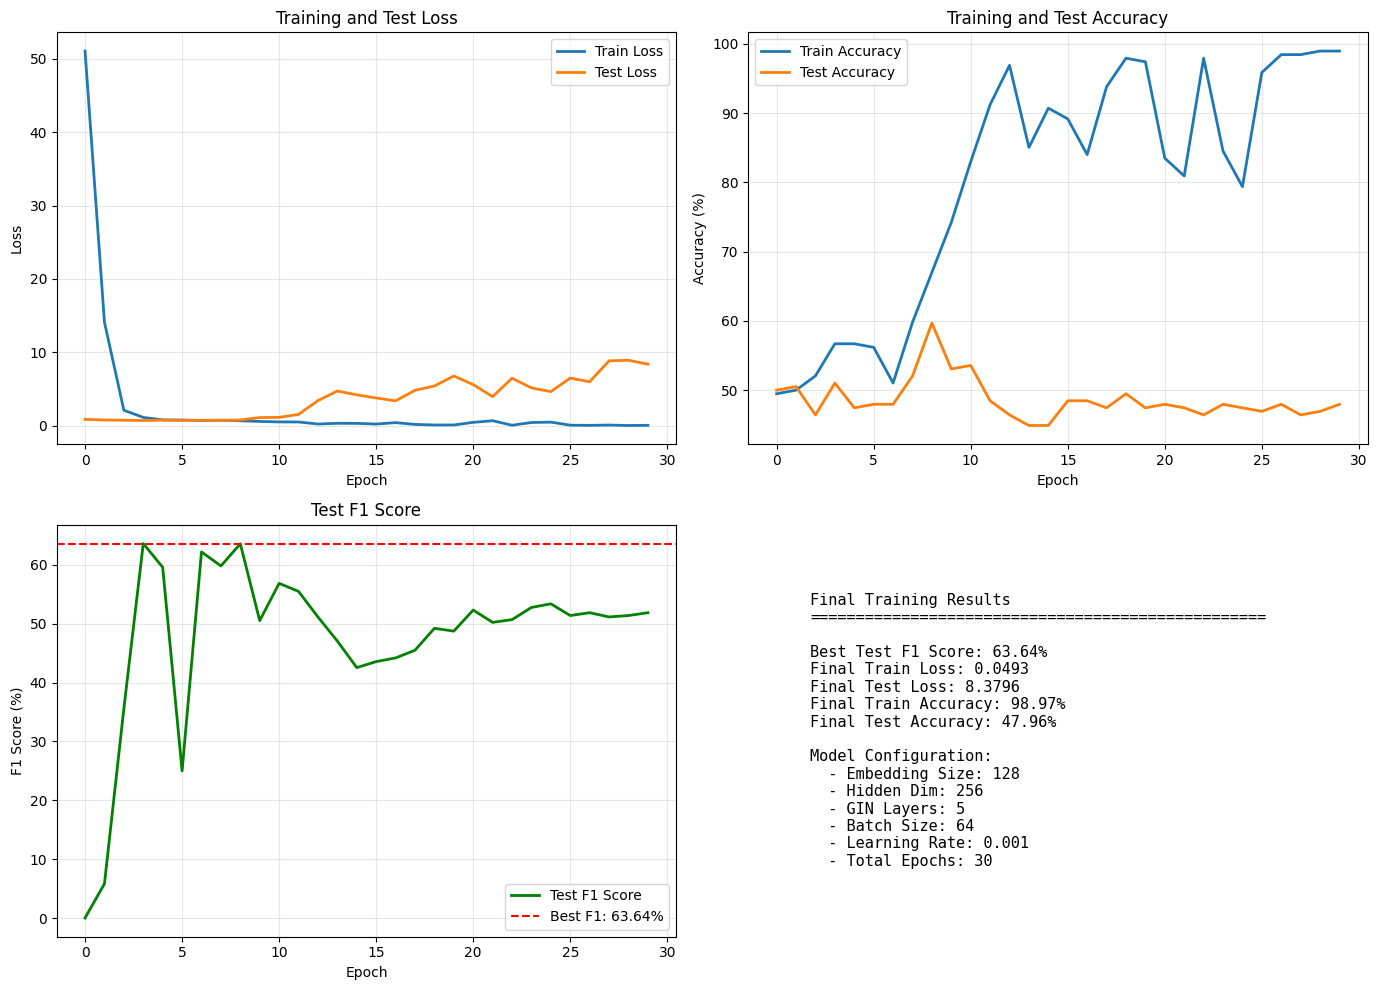

In [14]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0, 0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy curves
axes[0, 1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[0, 1].plot(test_accs, label='Test Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Test Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# F1 curve
axes[1, 0].plot(test_f1s, label='Test F1 Score', linewidth=2, color='green')
axes[1, 0].axhline(y=best_test_f1, color='r', linestyle='--', label=f'Best F1: {best_test_f1:.2f}%')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score (%)')
axes[1, 0].set_title('Test F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Summary statistics
axes[1, 1].axis('off')
summary_text = f"""
Final Training Results
{'='*50}

Best Test F1 Score: {best_test_f1:.2f}%
Final Train Loss: {train_losses[-1]:.4f}
Final Test Loss: {test_losses[-1]:.4f}
Final Train Accuracy: {train_accs[-1]:.2f}%
Final Test Accuracy: {test_accs[-1]:.2f}%

Model Configuration:
  - Embedding Size: {EMBEDDING_SIZE}
  - Hidden Dim: {HIDDEN_DIM}
  - GIN Layers: {NUM_LAYERS}
  - Batch Size: {BATCH_SIZE}
  - Learning Rate: {LEARNING_RATE}
  - Total Epochs: {NUM_EPOCHS}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Final Evaluation on Test Set

In [15]:
# Final evaluation with best model
print("Evaluating best model on test set...\n")
final_metrics = evaluate(model, test_loader, criterion, device)

print("="*70)
print("FINAL TEST SET RESULTS")
print("="*70)
print(f"Accuracy:  {final_metrics['accuracy']:.2f}%")
print(f"Precision: {final_metrics['precision']:.2f}%")
print(f"Recall:    {final_metrics['recall']:.2f}%")
print(f"F1 Score:  {final_metrics['f1']:.2f}%")
print(f"AUC-ROC:   {final_metrics['auc']:.4f}")
print("="*70)

Evaluating best model on test set...



FINAL TEST SET RESULTS
Accuracy:  47.96%
Precision: 48.25%
Recall:    56.12%
F1 Score:  51.89%
AUC-ROC:   0.5624


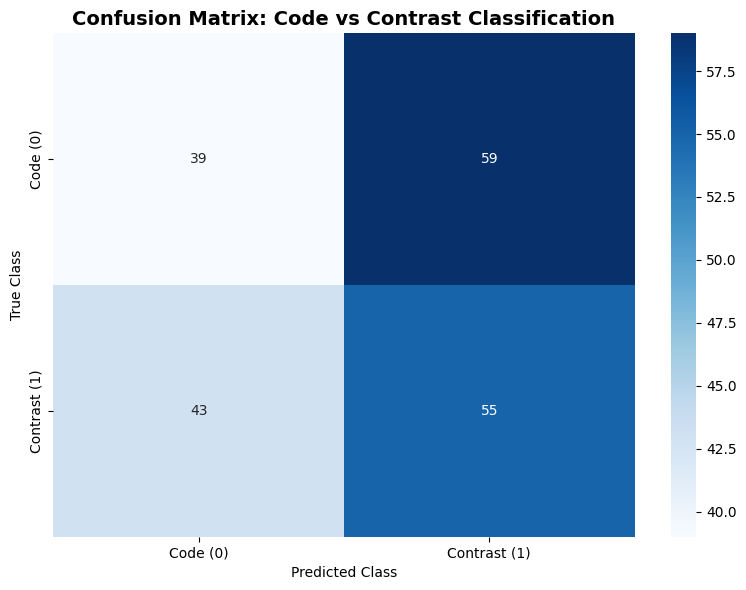


CONFUSION MATRIX
                     Predicted Code  Predicted Contrast
Actual Code               39               59        
Actual Contrast           43               55        


In [16]:
cm = confusion_matrix(final_metrics['labels'], final_metrics['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Code (0)', 'Contrast (1)'],
            yticklabels=['Code (0)', 'Contrast (1)'])
plt.title('Confusion Matrix: Code vs Contrast Classification', fontsize=14, fontweight='bold')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)
print(f"{'':20} Predicted Code  Predicted Contrast")
print(f"Actual Code         {cm[0,0]:^14} {cm[0,1]:^18}")
print(f"Actual Contrast     {cm[1,0]:^14} {cm[1,1]:^18}")
print("="*70)

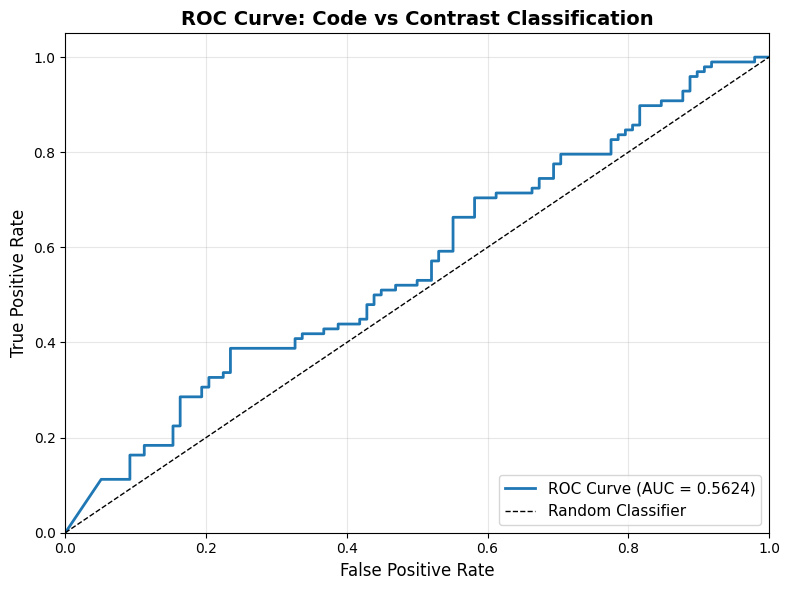

In [17]:
fpr, tpr, thresholds = roc_curve(final_metrics['labels'], final_metrics['probabilities'])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {final_metrics["auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve: Code vs Contrast Classification', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Error Analysis

In [18]:
predictions = np.array(final_metrics['predictions'])
labels = np.array(final_metrics['labels'])
probabilities = np.array(final_metrics['probabilities'])

# Find misclassified samples
misclassified_idx = np.where(predictions != labels)[0]
correct_idx = np.where(predictions == labels)[0]

print("\n" + "="*70)
print("MISCLASSIFICATION ANALYSIS")
print("="*70)
print(f"Total samples: {len(labels)}")
print(f"Correctly classified: {len(correct_idx)} ({100*len(correct_idx)/len(labels):.2f}%)")
print(f"Misclassified: {len(misclassified_idx)} ({100*len(misclassified_idx)/len(labels):.2f}%)")

# Breakdown by class
code_misclassified = np.where((predictions != labels) & (labels == 0))[0]
contrast_misclassified = np.where((predictions != labels) & (labels == 1))[0]

print(f"\nMisclassification breakdown:")
print(f"  Code → Contrast: {len(code_misclassified)} samples")
print(f"    (Real code incorrectly classified as contrast)")
print(f"  Contrast → Code: {len(contrast_misclassified)} samples")
print(f"    (Contrast incorrectly classified as real code)")
print("="*70)


MISCLASSIFICATION ANALYSIS
Total samples: 196
Correctly classified: 94 (47.96%)
Misclassified: 102 (52.04%)

Misclassification breakdown:
  Code → Contrast: 59 samples
    (Real code incorrectly classified as contrast)
  Contrast → Code: 43 samples
    (Contrast incorrectly classified as real code)


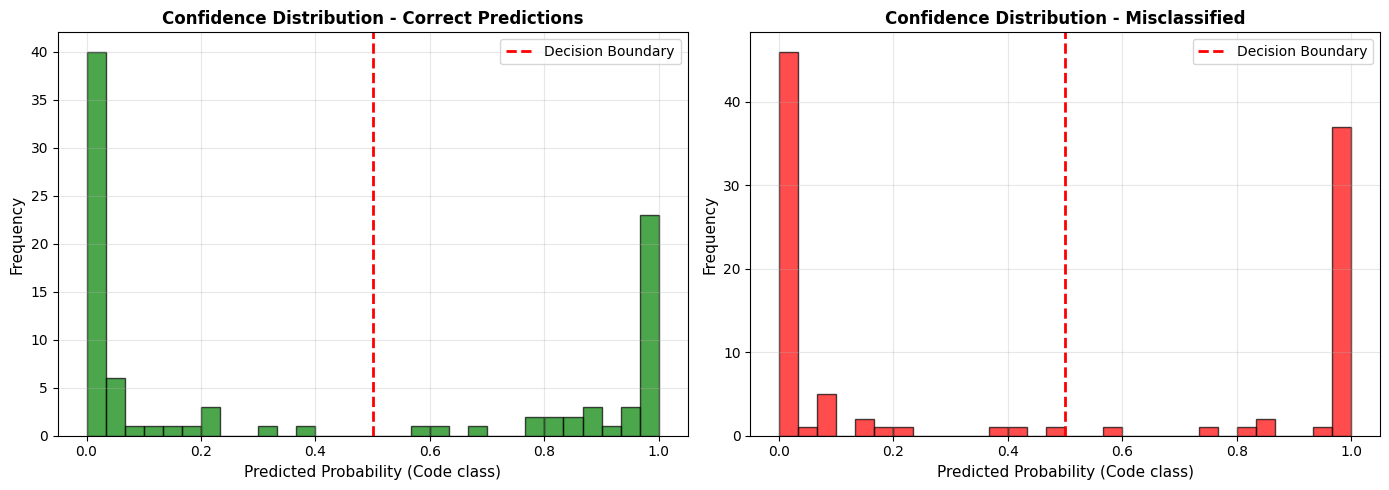

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence for correct predictions
correct_probs = probabilities[correct_idx]
axes[0].hist(correct_probs, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0].axvline(x=0.5, color='r', linestyle='--', linewidth=2, label='Decision Boundary')
axes[0].set_xlabel('Predicted Probability (Code class)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Confidence Distribution - Correct Predictions', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Confidence for misclassified predictions
if len(misclassified_idx) > 0:
    misclassified_probs = probabilities[misclassified_idx]
    axes[1].hist(misclassified_probs, bins=30, alpha=0.7, color='red', edgecolor='black')
    axes[1].axvline(x=0.5, color='r', linestyle='--', linewidth=2, label='Decision Boundary')
    axes[1].set_xlabel('Predicted Probability (Code class)', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].set_title('Confidence Distribution - Misclassified', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'No Misclassifications!', 
                ha='center', va='center', fontsize=16, fontweight='bold')
    axes[1].set_title('Confidence Distribution - Misclassified', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


## 9. Model Saving and Summary

In [20]:
# Save complete model checkpoint
checkpoint = {
    'model_state_dict': best_model_state,
    'vocab_size': vocab_size,
    'embedding_dim': EMBEDDING_SIZE,
    'hidden_dim': HIDDEN_DIM,
    'num_layers': NUM_LAYERS,
    'max_nodes': MAX_NODES,
    'best_test_f1': best_test_f1,
    'final_metrics': final_metrics,
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_accs': train_accs,
    'test_accs': test_accs,
    'test_f1s': test_f1s
}

torch.save(checkpoint, 'checkpoint.pth')
print("Complete checkpoint saved to 'checkpoint.pth'")

Complete checkpoint saved to 'checkpoint.pth'


In [21]:
# Save results summary
results_summary = {
    'model_config': {
        'embedding_size': EMBEDDING_SIZE,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'max_nodes': MAX_NODES,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS
    },
    'final_metrics': {
        'accuracy': float(final_metrics['accuracy']),
        'precision': float(final_metrics['precision']),
        'recall': float(final_metrics['recall']),
        'f1': float(final_metrics['f1']),
        'auc': float(final_metrics['auc'])
    },
    'confusion_matrix': cm.tolist(),
    'dataset_stats': {
        'train_size': len(valid_dataset),
        'test_size': len(test_dataset),
        'vocab_size': vocab_size
    }
}

with open('results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results summary saved to 'results_summary.json'")

Results summary saved to 'results_summary.json'


## 10. Sample Predictions

In [22]:
print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)
print("NOTE: We test BOTH code and contrast for each sample")
print("="*70)

num_examples = 5

for i in range(min(num_examples, len(test_dataset))):
    sample = test_dataset[i]
    
    # Prepare inputs
    code_graph = sample['code_graph'].unsqueeze(0).to(device)
    contrast_graph = sample['contrast_graph'].unsqueeze(0).to(device)
    code_seq = [sample['code_sequence']]
    contrast_seq = [sample['contrast_sequence']]
    code_num_nodes = [sample['code_num_nodes']]
    contrast_num_nodes = [sample['contrast_num_nodes']]
    
    model.eval()
    with torch.no_grad():
        # Test the CODE sample (should predict 0)
        code_logits = model(code_seq, code_graph, code_num_nodes,
                           contrast_seq, contrast_graph, contrast_num_nodes)
        code_probs = F.softmax(code_logits, dim=1)
        code_pred = torch.argmax(code_logits, dim=1).item()
        code_confidence = code_probs[0][code_pred].item()
        
        # Test the CONTRAST sample (should predict 1)
        contrast_logits = model(contrast_seq, contrast_graph, contrast_num_nodes,
                               code_seq, code_graph, code_num_nodes)
        contrast_probs = F.softmax(contrast_logits, dim=1)
        contrast_pred = torch.argmax(contrast_logits, dim=1).item()
        contrast_confidence = contrast_probs[0][contrast_pred].item()
    
    print(f"\n{'='*70}")
    print(f"Sample Pair {i+1} (Index: {sample['index']})")
    print(f"{'='*70}")
    
    print(f"\n  CODE sample:")
    print(f"    Expected: 0 (Code)")
    print(f"    Predicted: {code_pred} ({'Code' if code_pred == 0 else 'Contrast'})")
    print(f"    Confidence: {code_confidence*100:.2f}%")
    print(f"    Nodes: {sample['code_num_nodes']}")
    print(f"    {'✓ CORRECT' if code_pred == 0 else '✗ INCORRECT'}")
    
    print(f"\n  CONTRAST sample:")
    print(f"    Expected: 1 (Contrast)")
    print(f"    Predicted: {contrast_pred} ({'Code' if contrast_pred == 0 else 'Contrast'})")
    print(f"    Confidence: {contrast_confidence*100:.2f}%")
    print(f"    Nodes: {sample['contrast_num_nodes']}")
    print(f"    {'✓ CORRECT' if contrast_pred == 1 else '✗ INCORRECT'}")
    
    both_correct = (code_pred == 0) and (contrast_pred == 1)
    print(f"\n  Overall: {'✓✓ BOTH CORRECT' if both_correct else '✗ AT LEAST ONE WRONG'}")



SAMPLE PREDICTIONS
NOTE: We test BOTH code and contrast for each sample

Sample Pair 1 (Index: gp333488)

  CODE sample:
    Expected: 0 (Code)
    Predicted: 1 (Contrast)
    Confidence: 91.87%
    Nodes: 42
    ✗ INCORRECT

  CONTRAST sample:
    Expected: 1 (Contrast)
    Predicted: 1 (Contrast)
    Confidence: 91.60%
    Nodes: 38
    ✓ CORRECT

  Overall: ✗ AT LEAST ONE WRONG

Sample Pair 2 (Index: gp254519)

  CODE sample:
    Expected: 0 (Code)
    Predicted: 0 (Code)
    Confidence: 85.02%
    Nodes: 26
    ✓ CORRECT

  CONTRAST sample:
    Expected: 1 (Contrast)
    Predicted: 1 (Contrast)
    Confidence: 95.38%
    Nodes: 24
    ✓ CORRECT

  Overall: ✓✓ BOTH CORRECT

Sample Pair 3 (Index: gp320381)

  CODE sample:
    Expected: 0 (Code)
    Predicted: 1 (Contrast)
    Confidence: 86.50%
    Nodes: 130
    ✗ INCORRECT

  CONTRAST sample:
    Expected: 1 (Contrast)
    Predicted: 1 (Contrast)
    Confidence: 99.49%
    Nodes: 264
    ✓ CORRECT

  Overall: ✗ AT LEAST ONE WRONG
